# KakashiNet

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Packages

In [3]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thaisaraujom. Use `wandb login --relogin` to force relogin


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Implementing KakashiNet

<img src="https://drive.google.com/uc?export=view&id=16B1pZ4zsAfaXnE_Oeut7zKVSApb8AcKg">

In [6]:
class KakashiNet:
  ''' 
  # create KakashiNet model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  #      - 2 batchnormalization layers
  #      - 4 dropout layers
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => BN => POOL layers => DO
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='relu', input_shape=(28,28,1), )) #C1
    model.add(BatchNormalization()) #B1
    model.add(AveragePooling2D()) #S2
    model.add(Dropout(0.25)) #D1 .25

    # second set of CONV => RELU => BN => POOL layers => DO
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='relu')) #C3
    model.add(BatchNormalization()) #B2
    model.add(AveragePooling2D()) #S4
    model.add(Dropout(0.25)) #D2 .25

    # Flatten => FC => RELU => DO => FC => RELU => DO  
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu')) #F5
    model.add(Dropout(0.5)) #D3 
    model.add(Dense(84, activation='relu')) #F6
    model.add(Dropout(0.5)) #D4 

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [7]:
# create a model object
model = KakashiNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)       6

## Fetch, Preprocessing and Data Segregation

In [8]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "kakashinet"
}

In [9]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",
                 project=args["project_name"], 
                 job_type="Train")

In [10]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

25-10-2022 21:42:47 [INFO] accessing MNIST...
25-10-2022 21:42:48 Train x: (60000, 28, 28)
25-10-2022 21:42:48 Train y: (60000,)
25-10-2022 21:42:48 Test x: (10000, 28, 28)
25-10-2022 21:42:48 Test y: (10000,)


In [11]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [12]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

25-10-2022 21:42:48 Train x: (60000, 28, 28, 1)
25-10-2022 21:42:48 Train y: (60000,)
25-10-2022 21:42:48 Test x: (10000, 28, 28, 1)
25-10-2022 21:42:48 Test y: (10000,)


In [13]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

## Training

In [14]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = KakashiNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

25-10-2022 21:42:51 [INFO] compiling model...
25-10-2022 21:42:51 [INFO] training network...
25-10-2022 21:42:52 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


## Evaluation Metrics

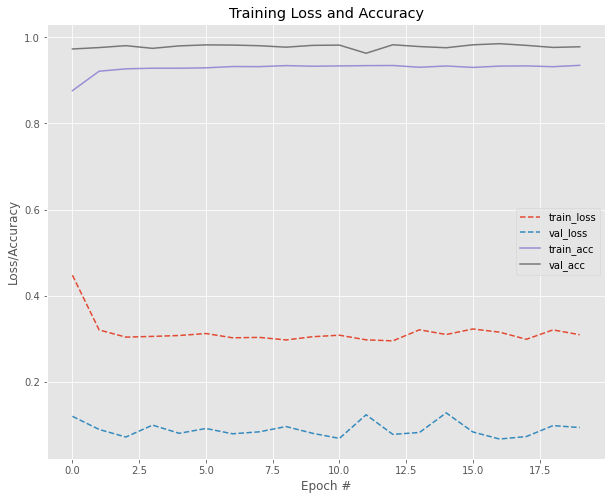

In [15]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [16]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.002978214472860811 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0001826505417671312 kWh
[INFO] Energy consumed for all GPU: 0.001162149742569592 kWh
[INFO] Energy consumed for all CPU: 0.0016334141885240875 kWh
[INFO] CO2 emission 0.0018792031894561093(in Kg)


In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       1.00      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.96      0.97      1028
           8       1.00      0.95      0.97       974
           9       0.91      0.98      0.94      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



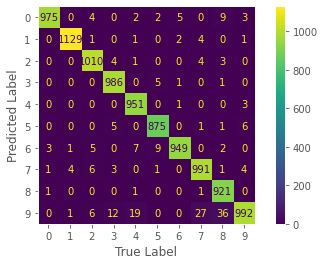

In [32]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [31]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

25-10-2022 22:32:41 Uploading figures


In [20]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

25-10-2022 21:45:11 Validation Evaluation metrics
25-10-2022 21:45:11 Validation Accuracy: 0.9779
25-10-2022 21:45:11 Validation Precision: 0.9786876257632457
25-10-2022 21:45:11 Validation Recall: 0.9779
25-10-2022 21:45:11 Validation F1: 0.9780219502106607


In [21]:
run.finish()

accuracy,▁▆▇▇▇▇███████▇█▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▂▂▁▁▁▁▂▁▁▂▂▂▂▁▂▂
val_accuracy,▄▅▇▅▆▇▇▇▅▇▇▁▇▆▅▇█▇▅▆
val_loss,▇▄▂▅▃▄▂▃▄▃▁█▂▃█▃▁▂▅▄
Acc,0.9779
CO2_Emissions,0.00188
Count_Params,61794
Energy_CPU,0.00163
Energy_Consumed,0.00298
Energy_GPU,0.00116


## Sweep (hyperparameter tuning)

In [22]:
# Configure the sweep 
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': {
            'max': 3,
            'min': 1,
            'distribution': 'int_uniform',
        },
        'learn_rate': {
            'values': [0.01,0.001,0.005],  
        },
        'epoch': {
            'values': [5,30]
        },
        'batch_size': {
            'values': [32,64]
        },
        'dropout':{
            'values' : [0.0, 0.25, 0.5]
        }
    }
}

In [23]:
class KakashiNetAdapt:

  @staticmethod
  def build(width, height, depth, classes, config):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # conv layer
    for i in range(config.conv_layer):
      model.add(Conv2D(6, (5,5), strides=1, padding='same', 
                       activation='relu', input_shape=inputShape)) #C1

    model.add(BatchNormalization()) #B1
    model.add(AveragePooling2D()) #S2
    model.add(Dropout(config.dropout)) #D1 .25

    for i in range(config.conv_layer):
      model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='relu')) #C3

    model.add(BatchNormalization()) #B2
    model.add(AveragePooling2D()) #S4
    model.add(Dropout(config.dropout)) #D2 .25

    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu')) #F5
    model.add(Dropout(config.dropout)) #D3 
    model.add(Dense(84, activation='relu')) #F6
    model.add(Dropout(config.dropout)) #D4 

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [24]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config,
                       entity="thaisaraujom",
                       project=args["project_name"])

Create sweep with ID: u8irvrp6
Sweep URL: https://wandb.ai/thaisaraujom/kakashinet/sweeps/u8irvrp6


#### Training

In [25]:
def train():
    with wandb.init() as run:
      # create codecarbon tracker
      # codecarbon is too much verbose, change the log level for more info
      tracker = EmissionsTracker(log_level="critical")
      tracker.start()

      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = Adam(learning_rate=run.config.learn_rate)
      model = KakashiNetAdapt.build(width=28, 
                               height=28,
                               depth=1, 
                               classes=10,
                               config=run.config)
      model.compile(loss="categorical_crossentropy", 
                    optimizer=opt,metrics=["accuracy"])

      # train the network
      print("[INFO] training network...")
      history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    batch_size=run.config.batch_size, 
                    epochs=run.config.epoch, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)]
                )

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()

      # make predictions
      predictions = model.predict(test_x, batch_size=run.config.batch_size)

      # Evaluation Metrics
      logger.info("Validation Evaluation metrics")
      fbeta = fbeta_score(test_y.argmax(axis=1), 
                          predictions.argmax(axis=1), 
                          beta=1, zero_division=1,average='weighted')
      precision = precision_score(test_y.argmax(axis=1),
                                  predictions.argmax(axis=1),
                                  zero_division=1,average='weighted')
      recall = recall_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
      acc = accuracy_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1))

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()
      logger.info("Validation Accuracy: {}".format(acc))
      logger.info("Validation Precision: {}".format(precision))
      logger.info("Validation Recall: {}".format(recall))
      logger.info("Validation F1: {}".format(fbeta))

      run.summary["Acc"] = acc
      run.summary["Precision"] = precision
      run.summary["Recall"] = recall
      run.summary["F1"] = fbeta
      # number of parameters
      run.summary["Count_Params"] = model.count_params()
      # energy unit is kWh
      run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
      run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
      run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
      run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
      # kg
      run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

In [26]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train,count=10)

wandb: Agent Starting Run: h6nucsjq with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.25
wandb: 	epoch: 30
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


25-10-2022 21:47:38 Validation Evaluation metrics
25-10-2022 21:47:39 Validation Accuracy: 0.9947
25-10-2022 21:47:39 Validation Precision: 0.9947069107926482
25-10-2022 21:47:39 Validation Recall: 0.9947
25-10-2022 21:47:39 Validation F1: 0.9946988004426867


accuracy,▁▆▇▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▂▄▆▆▇▅▇▇▇▇▇▇▇▇█▇▆██▇▇▇▇█▇▇█
val_loss,█▇▆█▆▃▂▂▄▂▂▂▂▂▂▂▁▁▂▃▁▁▁▂▂▂▁▂▂▁
Acc,0.9947
CO2_Emissions,0.00189
Count_Params,38396
Energy_CPU,0.00151
Energy_Consumed,0.00299
Energy_GPU,0.00131


wandb: Agent Starting Run: fw435n8r with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 5
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


25-10-2022 21:48:41 Validation Evaluation metrics
25-10-2022 21:48:41 Validation Accuracy: 0.9693
25-10-2022 21:48:41 Validation Precision: 0.9695810936082149
25-10-2022 21:48:41 Validation Recall: 0.9693
25-10-2022 21:48:41 Validation F1: 0.9692997369299272


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▅█▄▄
val_loss,█▅▁▅█
Acc,0.9693
CO2_Emissions,0.00059
Count_Params,61794
Energy_CPU,0.0005
Energy_Consumed,0.00093
Energy_GPU,0.00037


wandb: Agent Starting Run: 68f2r2p2 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0.25
wandb: 	epoch: 5
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


25-10-2022 21:49:31 Validation Evaluation metrics
25-10-2022 21:49:31 Validation Accuracy: 0.9884
25-10-2022 21:49:31 Validation Precision: 0.9885252312063365
25-10-2022 21:49:31 Validation Recall: 0.9884
25-10-2022 21:49:31 Validation F1: 0.9884011530801093


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆▇▁█
val_loss,▇▃▁█▁
Acc,0.9884
CO2_Emissions,0.00049
Count_Params,61794
Energy_CPU,0.00042
Energy_Consumed,0.00078
Energy_GPU,0.00031


wandb: Agent Starting Run: 5ffl28r1 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 30
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


25-10-2022 21:53:09 Validation Evaluation metrics
25-10-2022 21:53:09 Validation Accuracy: 0.989
25-10-2022 21:53:09 Validation Precision: 0.9890148892754176
25-10-2022 21:53:09 Validation Recall: 0.989
25-10-2022 21:53:09 Validation F1: 0.9889878978151304


accuracy,▁▆▇▇▇▇▇███████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇████▇█████▇█████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.989
CO2_Emissions,0.00279
Count_Params,61794
Energy_CPU,0.00237
Energy_Consumed,0.00442
Energy_GPU,0.00179


wandb: Agent Starting Run: rsd52k2d with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0
wandb: 	epoch: 30
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


25-10-2022 21:55:17 Validation Evaluation metrics
25-10-2022 21:55:17 Validation Accuracy: 0.9922
25-10-2022 21:55:17 Validation Precision: 0.9922231900353515
25-10-2022 21:55:17 Validation Recall: 0.9922
25-10-2022 21:55:17 Validation F1: 0.9921978590906325


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▆▄▄▅▅▅▇▇▇▇▇▆▇▆▇▆▇▆▅▇▆▆▇▆▇▅█
val_loss,▅▅▅▂▄▄▃▂▄▂▂▁▁▂▃▁▄▂▅▃▅█▃▇▆▅▆▆█▃
Acc,0.9922
CO2_Emissions,0.00159
Count_Params,61794
Energy_CPU,0.00133
Energy_Consumed,0.00251
Energy_GPU,0.00104


wandb: Agent Starting Run: ihle49ob with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	dropout: 0.5
wandb: 	epoch: 5
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


25-10-2022 21:56:00 Validation Evaluation metrics
25-10-2022 21:56:00 Validation Accuracy: 0.9845
25-10-2022 21:56:00 Validation Precision: 0.9845353215006849
25-10-2022 21:56:00 Validation Recall: 0.9845
25-10-2022 21:56:00 Validation F1: 0.9844918579483296


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅███
val_loss,█▃▂▂▁
Acc,0.9845
CO2_Emissions,0.00038
Count_Params,30358
Energy_CPU,0.0003
Energy_Consumed,0.00061
Energy_GPU,0.00027


wandb: Agent Starting Run: rq5wayqb with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0
wandb: 	epoch: 5
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


25-10-2022 21:56:49 Validation Evaluation metrics
25-10-2022 21:56:49 Validation Accuracy: 0.9896
25-10-2022 21:56:49 Validation Precision: 0.9896285459164975
25-10-2022 21:56:49 Validation Recall: 0.9896
25-10-2022 21:56:49 Validation F1: 0.9895915781694601


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▁▁▂▇█
val_loss,█▇▇▁▁
Acc,0.9896
CO2_Emissions,0.00044
Count_Params,61794
Energy_CPU,0.00037
Energy_Consumed,0.00069
Energy_GPU,0.00028


wandb: Agent Starting Run: h3l9iora with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	dropout: 0
wandb: 	epoch: 5
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


25-10-2022 21:57:30 Validation Evaluation metrics
25-10-2022 21:57:30 Validation Accuracy: 0.9852
25-10-2022 21:57:30 Validation Precision: 0.9853918437090204
25-10-2022 21:57:30 Validation Recall: 0.9852
25-10-2022 21:57:30 Validation F1: 0.9852104623494743


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁██▇▇
val_loss,█▁▁▂▂
Acc,0.9852
CO2_Emissions,0.00036
Count_Params,30358
Energy_CPU,0.00029
Energy_Consumed,0.00057
Energy_GPU,0.00024


wandb: Agent Starting Run: h30fj4a9 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	dropout: 0
wandb: 	epoch: 30
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


25-10-2022 22:00:01 Validation Evaluation metrics
25-10-2022 22:00:01 Validation Accuracy: 0.9918
25-10-2022 22:00:01 Validation Precision: 0.991869605996212
25-10-2022 22:00:01 Validation Recall: 0.9918
25-10-2022 22:00:01 Validation F1: 0.991799144633608


accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▁▁▆▅▇▅▆▇▆▇█▇▇▇█▇█▆█▇█▇▇▇█▇▆█▇
val_loss,▄█▇▃▃▂▄▂▂▂▂▁▂▂▃▁▃▁▃▁▂▂▃▃▂▃▂▆▁▁
Acc,0.9918
CO2_Emissions,0.00206
Count_Params,30358
Energy_CPU,0.00158
Energy_Consumed,0.00327
Energy_GPU,0.00151


wandb: Agent Starting Run: rmnvvvzh with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 3
wandb: 	dropout: 0
wandb: 	epoch: 5
wandb: 	learn_rate: 0.005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


25-10-2022 22:01:45 Validation Evaluation metrics
25-10-2022 22:01:45 Validation Accuracy: 0.9915
25-10-2022 22:01:45 Validation Precision: 0.9915548635726431
25-10-2022 22:01:45 Validation Recall: 0.9915
25-10-2022 22:01:45 Validation F1: 0.9915053800712088


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▄▇▆█
val_loss,█▆▃▃▁
Acc,0.9915
CO2_Emissions,0.00117
Count_Params,30358
Energy_CPU,0.00099
Energy_Consumed,0.00186
Energy_GPU,0.00075


In [27]:
run.finish()